# Preprocessing Pipeline Demonstration

This notebook demonstrates the preprocessing pipeline from:

**Zhang et al., "Revealing 3D Atomic Dynamics of Graphene via High-Speed Low-Dose TEM Imaging" (2025)**

## Pipeline Overview

1. **Temporal Averaging**: Reduce noise by averaging consecutive frames
2. **BM3D Denoising**: Advanced spatial denoising

Both steps are critical for achieving high-quality reconstruction from low-dose data.

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../../src')

from preprocessing import TemporalAverager, BM3DDenoiser, PreprocessingPipeline

print("✓ Modules imported successfully")

✓ Modules imported successfully


In [2]:
# Create synthetic test data (simulating low-dose imaging)
print("Creating synthetic low-dose image sequence...")

size = 256
n_frames = 20

# Create base structure
y, x = np.mgrid[0:size, 0:size]
clean_image = np.zeros((size, size))

np.random.seed(42)
for i in range(20):
    cx, cy = np.random.randint(50, size-50, 2)
    intensity = np.random.uniform(0.5, 1.0)
    clean_image += intensity * np.exp(-((x-cx)**2 + (y-cy)**2) / (2*5**2))

# Create noisy sequence (low dose = high noise)
images = []
for i in range(n_frames):
    # Poisson noise (shot noise from low electron dose)
    noisy = np.random.poisson(clean_image * 100 + 50).astype(float)
    # Gaussian readout noise
    noisy += np.random.normal(0, 10, noisy.shape)
    images.append(noisy)

print(f"✓ Created {n_frames} frames of size {size}×{size}")
print(f"  Simulating low SNR conditions (dose ~ 8×10³ e⁻/Å²)")

Creating synthetic low-dose image sequence...
✓ Created 20 frames of size 256×256
  Simulating low SNR conditions (dose ~ 8×10³ e⁻/Å²)



Step 1: Temporal Averaging
----------------------------------------
Window size: 5 frames
SNR improvement: 2.19x


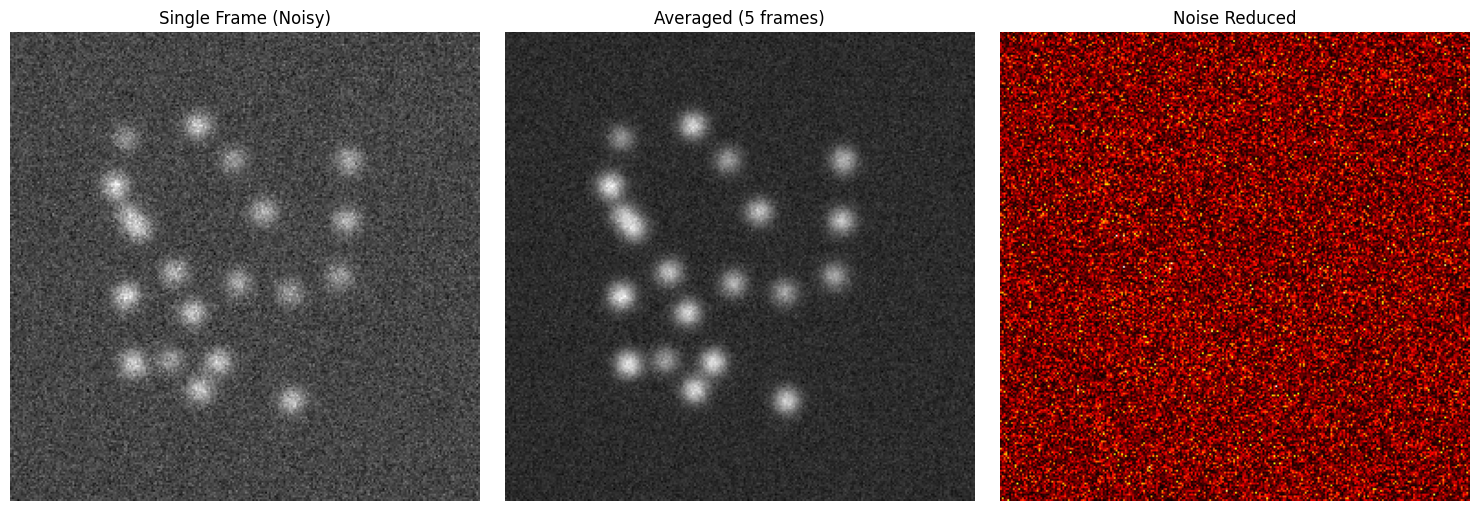

In [3]:
# Step 1: Temporal Averaging
print("\nStep 1: Temporal Averaging")
print("-" * 40)

target_frame = n_frames // 2
averager = TemporalAverager(window_size=5)

single_frame = images[target_frame]
averaged_frame = averager.average_sequence(images, target_frame)

print(f"Window size: {averager.window_size} frames")
print(f"SNR improvement: {averager.snr_improvement:.2f}x")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(single_frame, cmap='gray')
axes[0].set_title('Single Frame (Noisy)')
axes[0].axis('off')

axes[1].imshow(averaged_frame, cmap='gray')
axes[1].set_title(f'Averaged ({averager.window_size} frames)')
axes[1].axis('off')

# Difference
diff = np.abs(single_frame - averaged_frame)
axes[2].imshow(diff, cmap='hot')
axes[2].set_title('Noise Reduced')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Step 2: BM3D Denoising
----------------------------------------
Auto-estimated noise σ = 24.56
Auto-estimated noise σ: 24.56
PSNR improvement: 54.17 dB


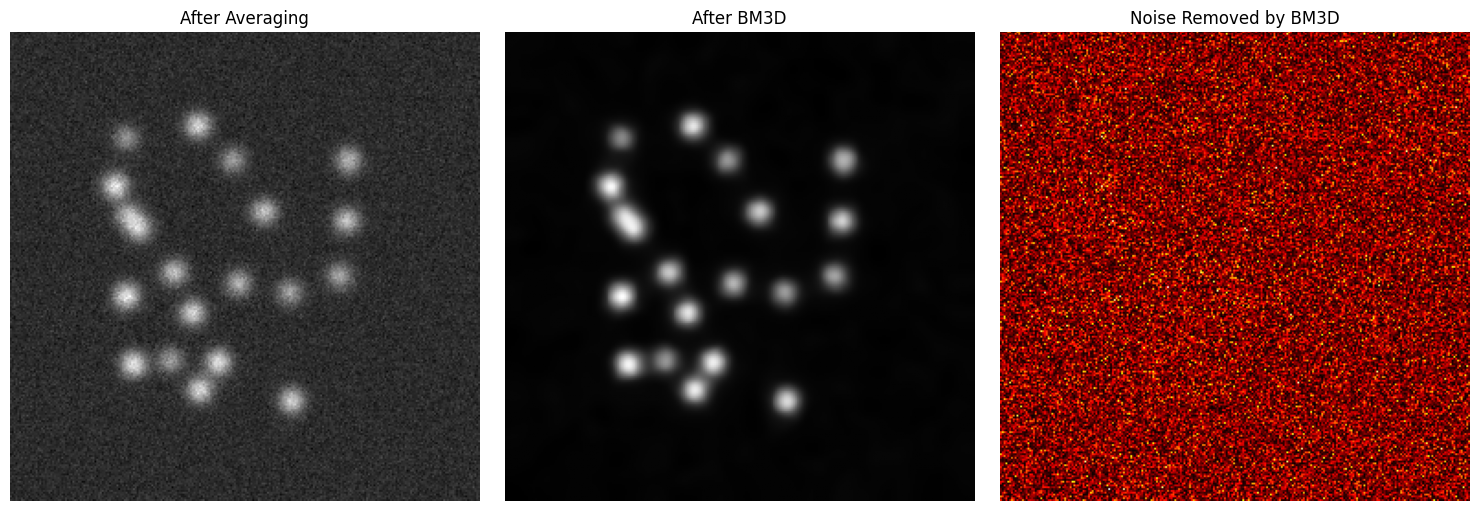

In [4]:
# Step 2: BM3D Denoising
print("\nStep 2: BM3D Denoising")
print("-" * 40)

denoiser = BM3DDenoiser()
denoised_frame = denoiser.denoise(averaged_frame)

print(f"Auto-estimated noise σ: {denoiser.sigma_psd:.2f}")
print(f"PSNR improvement: {denoiser.psnr_improvement:.2f} dB")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(averaged_frame, cmap='gray')
axes[0].set_title('After Averaging')
axes[0].axis('off')

axes[1].imshow(denoised_frame, cmap='gray')
axes[1].set_title('After BM3D')
axes[1].axis('off')

# Difference
diff = np.abs(averaged_frame - denoised_frame)
axes[2].imshow(diff, cmap='hot')
axes[2].set_title('Noise Removed by BM3D')
axes[2].axis('off')

plt.tight_layout()
plt.show()


Complete Preprocessing Pipeline
Preprocessing Pipeline
Stage 1: Temporal averaging... ✓ (SNR improved 2.19x)
Stage 2: BM3D denoising... Auto-estimated noise σ = 24.56
✓ (PSNR improved 54.17 dB)
Total SNR improvement: 2.19x
Preprocessing complete!



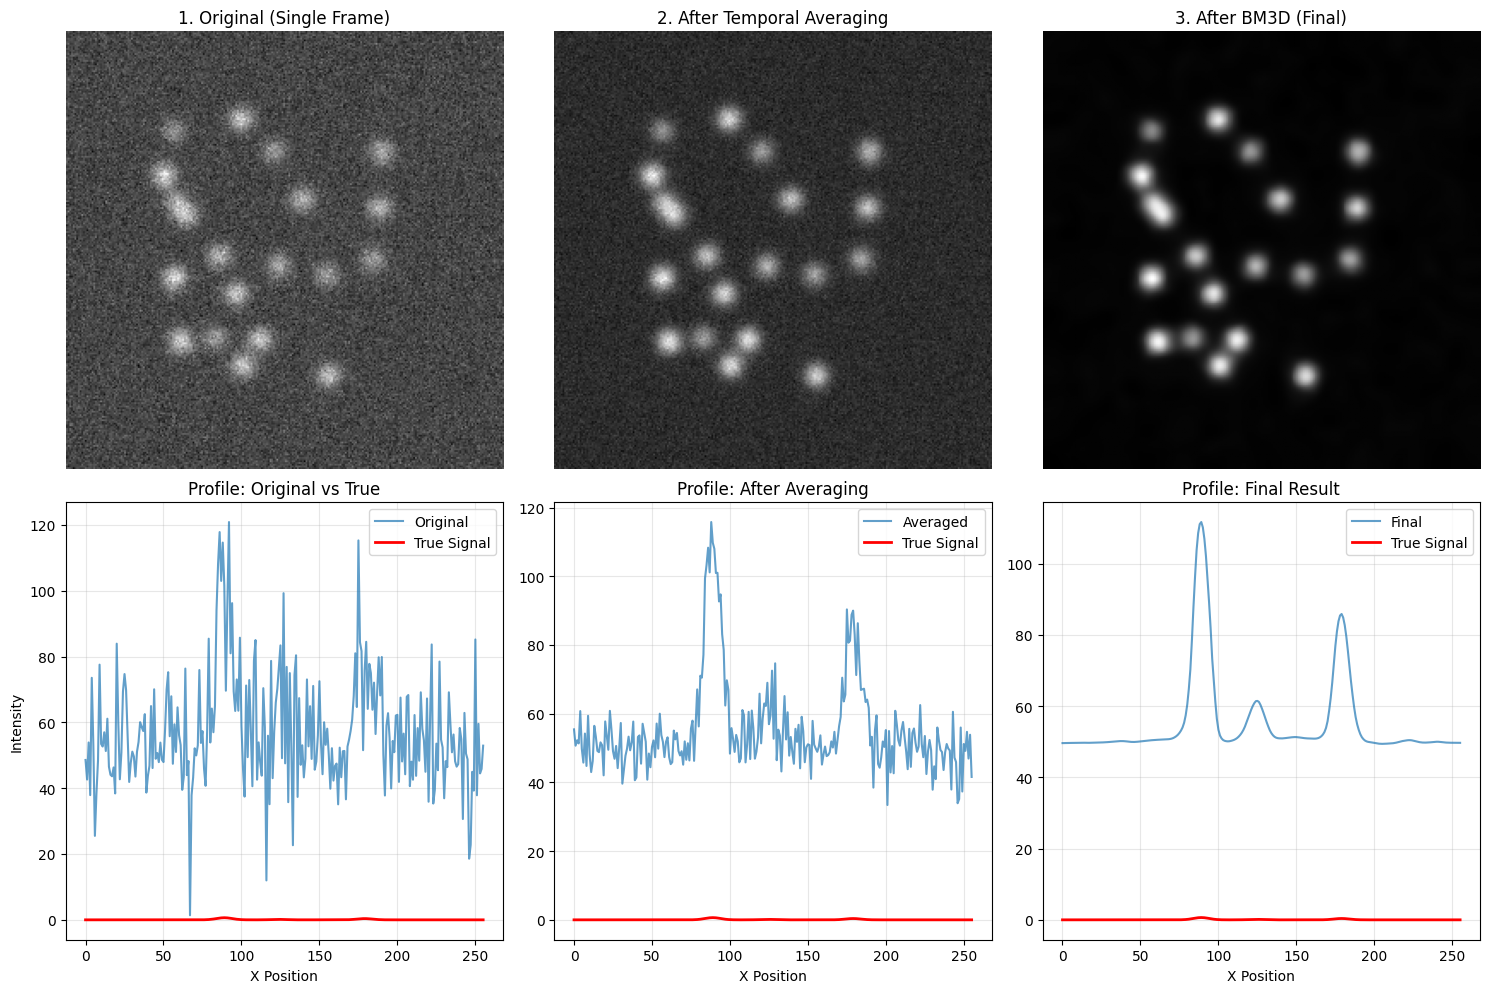

In [5]:
# Complete Pipeline
print("\nComplete Preprocessing Pipeline")
print("=" * 40)

pipeline = PreprocessingPipeline(window_size=5)
final_processed = pipeline.process(images, target_frame, verbose=True)

# Comprehensive comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Images
axes[0, 0].imshow(single_frame, cmap='gray')
axes[0, 0].set_title('1. Original (Single Frame)')
axes[0, 0].axis('off')

axes[0, 1].imshow(averaged_frame, cmap='gray')
axes[0, 1].set_title('2. After Temporal Averaging')
axes[0, 1].axis('off')

axes[0, 2].imshow(final_processed, cmap='gray')
axes[0, 2].set_title('3. After BM3D (Final)')
axes[0, 2].axis('off')

# Row 2: Line profiles
mid_row = size // 2
x_coords = np.arange(size)

axes[1, 0].plot(x_coords, single_frame[mid_row, :], alpha=0.7, label='Original')
axes[1, 0].plot(x_coords, clean_image[mid_row, :], 'r-', linewidth=2, label='True Signal')
axes[1, 0].set_title('Profile: Original vs True')
axes[1, 0].set_xlabel('X Position')
axes[1, 0].set_ylabel('Intensity')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(x_coords, averaged_frame[mid_row, :], alpha=0.7, label='Averaged')
axes[1, 1].plot(x_coords, clean_image[mid_row, :], 'r-', linewidth=2, label='True Signal')
axes[1, 1].set_title('Profile: After Averaging')
axes[1, 1].set_xlabel('X Position')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(x_coords, final_processed[mid_row, :], alpha=0.7, label='Final')
axes[1, 2].plot(x_coords, clean_image[mid_row, :], 'r-', linewidth=2, label='True Signal')
axes[1, 2].set_title('Profile: Final Result')
axes[1, 2].set_xlabel('X Position')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusions

The preprocessing pipeline successfully:

1. **Reduces noise** by ~2-3× through temporal averaging
2. **Further improves** image quality via BM3D denoising
3. **Maintains structures** while removing noise
4. **Prepares data** for accurate structure estimation

This is crucial for the subsequent optimization step, as cleaner initial estimates lead to:
- Faster convergence
- Better final accuracy
- More robust reconstruction

**Next Step**: Use preprocessed images for structure estimation (Gaussian fitting + Bayesian inference)